In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_kuramoto import KuramotoModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

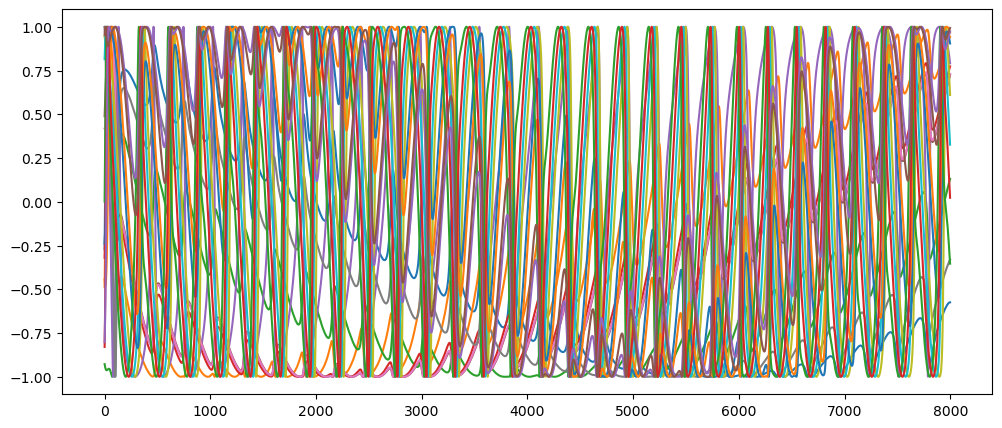

In [20]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kura_train = KuramotoModel(steps=8000, dt=0.01, sz=16, groups=2, coupling=0.21)
timeserie, timeserie_next, _, _ = kura_train.simulate_oneserie(sample_step=5)

plt.figure(figsize=(12,5))
for i in range(16):
    plt.plot(timeserie[:,i])
plt.show()

In [3]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kur_train = KuramotoModel(steps=8000, dt=0.01, sz=16, groups=2, coupling=0.21, sample_step=5)
kur_test = KuramotoModel(steps=500, dt=0.01, sz=16, groups=2, coupling=0.23, sample_step=5)
train_data = [torch.FloatTensor(kur_train.input).to(device), torch.FloatTensor(kur_train.output).to(device)]
test_data = [torch.FloatTensor(kur_test.input).to(device), torch.FloatTensor(kur_test.output).to(device)]

# Train

In [4]:
# train params

T_total = 15001
clip = 300
sz = 16
scale = 2
hidden_units = 64
batch_size = 128

# RNIS

In [ ]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=32,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()
param_counts_rnis = trainer.param_counts

check point------step-> 10:58:28.526421; lasting 0:00:45.109862 seconds
Epoch: 0
Train loss: 0.0029
Test loss: 0.8944
dEI: 0.1845
term1: -0.9432
term2: 1.3121
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:58:40.469092; lasting 0:00:11.942671 seconds
Epoch: 300
Train loss: 0.7309
Test loss: 0.7034
dEI: 0.6191
term1: -0.3606
term2: 1.5989
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:58:52.366390; lasting 0:00:11.897298 seconds
Epoch: 600
Train loss: 0.5398
Test loss: 0.6697
dEI: 0.8127
term1: -0.1406
term2: 1.7659
------------------------------------------------------------------------------------------------------------------------
check point------step-> 10:59:04.097949; lasting 0:00:11.731559 seconds
Epoch: 900
Train loss: 0.5006
Test loss: 0.6664
dEI: 0.8713
term1: -0.2003
term2: 1.

# NIS

In [ ]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
param_counts_nis = trainer.param_counts

# NIS+

In [ ]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=1, batch_size=batch_size, clip=clip)
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
param_counts_nisp = trainer.param_counts

# Result

In [10]:
print(param_counts_nis, param_counts_nisp, param_counts_rnis)

42210 46692 42600


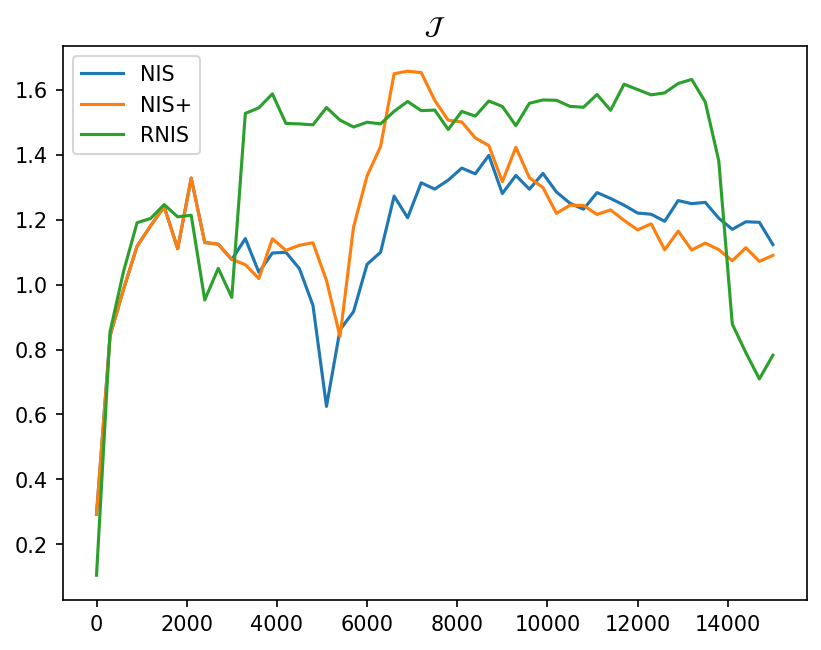

In [11]:
plt.figure(dpi=150)
timeseries = np.arange(len(trainer.eis)) * clip
plt.plot(timeseries, eis_nis, label='NIS')
plt.plot(timeseries, eis_nisp, label='NIS+')
timeseries = np.arange(len(eis_rnis)) * clip
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

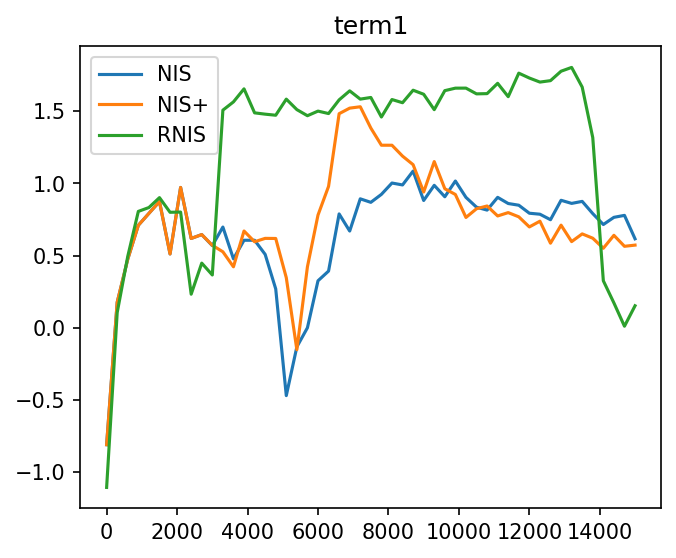

In [12]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term1s_nis, label='NIS')
plt.plot(timeseries, term1s_nisp, label='NIS+')
timeseries = np.arange(len(term1s_rnis)) * clip
plt.plot(timeseries, term1s_rnis, label='RNIS')
plt.title(r'term1')
plt.legend()
# plt.yscale('log')
plt.show()

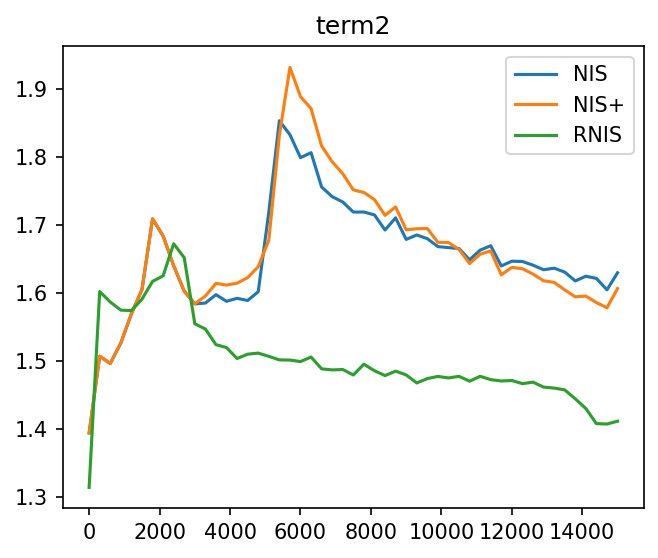

In [13]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term2s_nis, label='NIS')
plt.plot(timeseries, term2s_nisp, label='NIS+')
timeseries = np.arange(len(term2s_rnis)) * clip
plt.plot(timeseries, term2s_rnis, label='RNIS')
plt.title(r'term2')
plt.legend()
# plt.yscale('log')
plt.show()

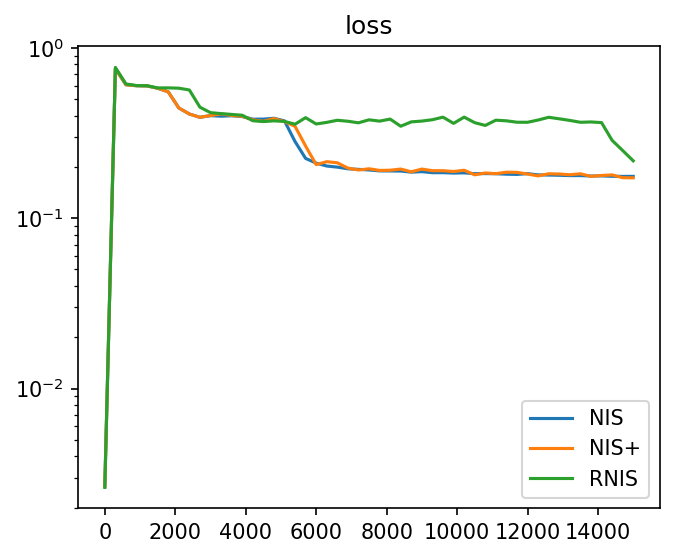

In [14]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, losses_nis, label='NIS')
plt.plot(timeseries, losses_nisp, label='NIS+')
timeseries = np.arange(len(losses_rnis)) * clip
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

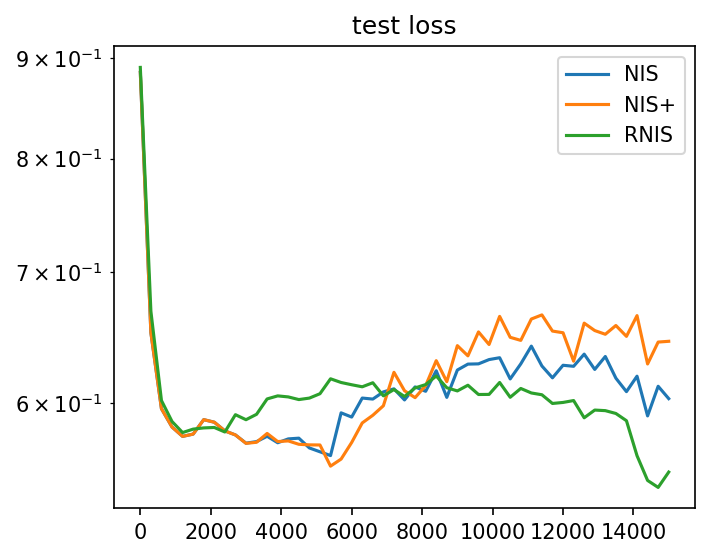

In [15]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
timeseries = np.arange(len(MAEs_mstep_rnis)) * clip
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'test loss')
plt.legend()
plt.yscale('log')
plt.show()